In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from helper import get_feature, find_patient_info

warnings.filterwarnings("ignore")

In [2]:
folder_path = "../../../Anemia_data/patient_wise_annotated"
annotated_folder = os.listdir(folder_path)
id_list = []
for id_folder_name in annotated_folder:
    id_folder = os.listdir(f"{folder_path}/{id_folder_name}")
    if len(id_folder)>0:
#         print(id_folder_name)
        id_list.append(int(id_folder_name.split("_")[1]))

In [3]:
(id_list_sorted) = sorted(id_list)

In [4]:
data_root = "c:/Users/HMILAB/Desktop/Tony"
race_group = np.load(data_root+"/Anemia_data/race_group.npy", allow_pickle=True).item()
id_header_group = np.load(data_root+"/Anemia_data/id_header_group.npy", allow_pickle=True).item()

In [5]:
info_csv = pd.read_csv(f"{data_root}/Anemia_data/revised_csv.csv")
print(info_csv)

      record_id   hct   hgb age  race  gender  Unnamed: 6  Unnamed: 7  \
0             1  39.1  13.1  21     5     0.0         NaN         NaN   
1             2  43.6  14.6  33     2     1.0         NaN         NaN   
2             3  41.7  14.2  48     5     1.0         NaN         NaN   
3             4  39.1  13.1  31     5     0.0         NaN         NaN   
4             5  37.2  11.8  79     3     0.0         NaN         NaN   
...         ...   ...   ...  ..   ...     ...         ...         ...   
1146       1147  31.9   9.6  79     3     NaN         NaN         NaN   
1147       1148  30.3   9.9  72     5     NaN         NaN         NaN   
1148       1149  25.2     8  65     5     NaN         NaN         NaN   
1149       1150  29.8   9.2  68     5     NaN         NaN         NaN   
1150       1151  32.4  10.2  70     5     NaN         NaN         NaN   

      Unnamed: 8  Unnamed: 9  Unnamed: 10  
0            NaN         NaN          NaN  
1            NaN         NaN       

In [6]:
race_group

{1:       record_id   hct   hgb   age  race  gender  label  int_hgb
 217         218  47.5  15.8  39.0     1     1.0      1       15
 329         330  41.5  13.8  70.0     1     1.0      1       13
 820         821  40.4  13.4  53.0     1     0.0      1       13
 1084       1085  31.7  10.7  57.0     1     NaN      0       10,
 2:       record_id   hct   hgb   age  race  gender  label  int_hgb
 1             2  43.6  14.6  33.0     2     1.0      1       14
 32           33  37.7  12.6  36.0     2     0.0      1       12
 168         169  37.0  12.2  33.0     2     0.0      0       12
 233         234  37.7  12.7  57.0     2     1.0      1       12
 261         262  44.4  14.9  61.0     2     1.0      1       14
 267         268  47.7  16.3  22.0     2     1.0      1       16
 298         299  42.8  14.1  23.0     2     0.0      1       14
 326         327  42.2  14.2  30.0     2     1.0      1       14
 352         353  37.0  12.2  32.0     2     0.0      0       12
 420         421  

In [67]:
x_inp_list = []
y_inp_list = []
image_path_dict = {}
instance_mask_path_dict = {}
feature_dict = {}
label_dict = {}
for index in id_list_sorted:
#     index=883
    try:
        hgb, age, race, gender, label = find_patient_info(index, info_csv)
    except:
        continue
    for i in range(len(id_header_group[index])):
        if id_header_group[index]["field_name"].iloc[i]=="eyeimage5":
            stored_name = id_header_group[index]["stored_name"].iloc[i]
            stored_name_split = id_header_group[index]["stored_name"].iloc[i].split(".")[0]
            
            an_path = data_root+f"/Anemia_data/patient_wise_annotated/id_{index}/{stored_name_split}.png"
            image_path = data_root+f"/Anemia_data/patient_wise_data/id_{index}/{stored_name}"
            image_path_dict[index] = image_path
            instance_mask_path_dict[index] = an_path
            
            instance_mask = cv2.imread(an_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            segment_image = cv2.bitwise_and(image, image, mask=instance_mask)
            segment_image = cv2.resize(segment_image, (256, 256))
            instance_mask = cv2.resize(instance_mask, (256, 256))
#             break
            
            #RGB feature
            feature_dict=get_feature("RGB", segment_image, instance_mask, feature_dict)

            #HSV feature
            hsv_segment_image = cv2.cvtColor(segment_image, cv2.COLOR_RGB2HSV)
            feature_dict=get_feature("HSV", hsv_segment_image, instance_mask, feature_dict)

        # #     #ycbcr feature
        #     ycbcr_image = cv2.cvtColor(segment_image, cv2.COLOR_RGB2YCrCb)
        #     feature_dict=get_feature("ycbcr", hsv_segment_image, instance_mask, feature_dict)

        # #     #LAB feature
        #     LAB_image = cv2.cvtColor(segment_image, cv2.COLOR_RGB2LAB)
        #     feature_dict=get_feature("LAB", hsv_segment_image, instance_mask, feature_dict)

        # #     #LUV feature
        #     LUV_image = cv2.cvtColor(segment_image, cv2.COLOR_RGB2LUV)
        #     feature_dict=get_feature("LUV", hsv_segment_image, instance_mask, feature_dict)

        # #     #XYZ feature
        #     XYZ_image = cv2.cvtColor(segment_image, cv2.COLOR_RGB2XYZ)
        #     feature_dict=get_feature("XYZ", hsv_segment_image, instance_mask, feature_dict)

            try:
                feature_dict["age"] = float(age)
            except:
                continue
            try:
                feature_dict["race"] = float(race)
            except:
                continue
            try:
                feature_dict["gender"] = float(gender)
            except:
                continue
            label_dict["label"] = label
            try:
                label_dict["hgb"] = float(hgb)
            except:
                continue
            x_inp_list.append(pd.DataFrame(feature_dict, index=[index]))
#             y_inp_list.append(pd.DataFrame(label, columns = ["label"], index=[index]))
            y_inp_list.append(pd.DataFrame(label_dict, index=[index]))
            break
#     break
            

KeyboardInterrupt: 

In [68]:
# plt.imshow(hsv_segment_image)

In [69]:
# plt.imshow(hsv_segment_image[:, :, 2])

In [70]:
# plt.imshow(image)

In [71]:
# plt.imshow(instance_mask)

In [72]:
x_inp = pd.concat(x_inp_list)
y_inp = pd.concat(y_inp_list)

In [73]:
x_inp = x_inp.dropna()
y_inp = y_inp.loc[x_inp.index]

Text(0, 0.5, 'hgb')

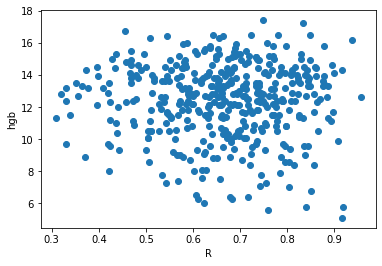

In [75]:

plt.scatter(x_inp["RGB_mean1"], y_inp["hgb"])
plt.xlabel("R")
plt.ylabel("hgb")

In [27]:
x_inp.columns

Index(['RGB_mean1', 'RGB_mean2', 'RGB_mean3', 'RGB_ALL_mean',
       'RGB_mean1/mean2', 'RGB_mean1/mean3', 'RGB_mean2/mean1',
       'RGB_mean2/mean3', 'RGB_mean3/mean1', 'RGB_mean3/mean2', 'RGB_std1',
       'RGB_std2', 'RGB_std3', 'RGB_std1/std2', 'RGB_std1/std3',
       'RGB_std2/std1', 'RGB_std2/std3', 'RGB_std3/std1', 'RGB_std3/std2',
       'HSV_mean1', 'HSV_mean2', 'HSV_mean3', 'HSV_ALL_mean',
       'HSV_mean1/mean2', 'HSV_mean1/mean3', 'HSV_mean2/mean1',
       'HSV_mean2/mean3', 'HSV_mean3/mean1', 'HSV_mean3/mean2', 'HSV_std1',
       'HSV_std2', 'HSV_std3', 'HSV_std1/std2', 'HSV_std1/std3',
       'HSV_std2/std1', 'HSV_std2/std3', 'HSV_std3/std1', 'HSV_std3/std2',
       'age', 'race', 'gender'],
      dtype='object')

In [28]:
x_inp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742 entries, 2 to 1053
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RGB_mean1        742 non-null    float64
 1   RGB_mean2        742 non-null    float64
 2   RGB_mean3        742 non-null    float64
 3   RGB_ALL_mean     742 non-null    float64
 4   RGB_mean1/mean2  742 non-null    float64
 5   RGB_mean1/mean3  742 non-null    float64
 6   RGB_mean2/mean1  742 non-null    float64
 7   RGB_mean2/mean3  742 non-null    float64
 8   RGB_mean3/mean1  742 non-null    float64
 9   RGB_mean3/mean2  742 non-null    float64
 10  RGB_std1         742 non-null    float64
 11  RGB_std2         742 non-null    float64
 12  RGB_std3         742 non-null    float64
 13  RGB_std1/std2    742 non-null    float64
 14  RGB_std1/std3    742 non-null    float64
 15  RGB_std2/std1    742 non-null    float64
 16  RGB_std2/std3    742 non-null    float64
 17  RGB_std3/std1  

In [29]:
y_inp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742 entries, 2 to 1053
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   742 non-null    bool 
dtypes: bool(1)
memory usage: 6.5 KB


In [39]:
from sklearn.ensemble import RandomForestClassifier
def rf_classifier_fun(X_train, y_train, X_test, y_test, max_depth):
    rfModel = RandomForestClassifier(max_depth=max_depth)

    rfModel.fit(X_train, y_train)

    return rfModel.score(X_train, y_train), rfModel.score(X_test,y_test), rfModel

In [40]:
all_train_score = 0
all_test_score = 0
test_time = 50
depth=[3,4,5,6,7,8,9]
# all_train_score=[0,0,0,0,0]
# all_test_score=[0,0,0,0,0]
select_index = x_inp.columns
importance=np.zeros(len(select_index))

for j in range(len(depth)):
    all_train_score = 0
    all_test_score = 0
    for i in range(test_time):
        X_train, X_test, y_train, y_test = train_test_split(x_inp[select_index], y_inp, test_size=0.1)
        train_score, test_score, model = rf_classifier_fun(X_train, y_train, X_test, y_test, max_depth=depth[j])
#         importance+=(model.feature_importances_)
        all_train_score+=train_score
        all_test_score+=test_score
    print("rf score : ", all_train_score/test_time, all_test_score/test_time, ", depth : ", depth[j])

rf score :  0.7105547226386807 0.6232 , depth :  3
rf score :  0.8175112443778113 0.6272 , depth :  5
rf score :  0.9248275862068964 0.648 , depth :  7
rf score :  0.9831784107946029 0.6258666666666667 , depth :  9


In [41]:
y_pred = model.predict(X_test)

In [45]:
y_test

,label
448,True
369,False
346,False
730,True
58,True
...,...
859,False
172,True
269,False
715,False


In [63]:
X_test.loc[bad_index].describe()

,RGB_mean1,RGB_mean2,RGB_mean3,RGB_ALL_mean,RGB_mean1/mean2,RGB_mean1/mean3,RGB_mean2/mean1,RGB_mean2/mean3,RGB_mean3/mean1,RGB_mean3/mean2,...,HSV_std3,HSV_std1/std2,HSV_std1/std3,HSV_std2/std1,HSV_std2/std3,HSV_std3/std1,HSV_std3/std2,age,race,gender
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,...,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,0.631229,0.426975,0.356829,0.471678,1.503045,1.845869,0.669966,1.223055,0.555043,0.825026,...,0.068726,0.149619,0.091665,13.357494,0.773896,18.329015,1.475439,55.714286,4.535714,0.642857
std,0.135302,0.112642,0.112193,0.117785,0.131009,0.293819,0.055738,0.118262,0.087769,0.079773,...,0.031103,0.271421,0.116652,6.012289,0.315899,9.055173,0.504119,17.659028,0.922241,0.487950
min,0.339325,0.203824,0.145232,0.229460,1.302498,1.352473,0.527286,1.013779,0.410285,0.677275,...,0.023974,0.036194,0.026108,0.692038,0.414282,1.670453,0.595915,22.000000,2.000000,0.000000
25%,0.525657,0.358573,0.296157,0.394357,1.398878,1.635145,0.635150,1.126422,0.490373,0.766782,...,0.051223,0.060943,0.043009,11.447518,0.537887,11.587000,1.173860,45.750000,5.000000,0.000000
50%,0.674564,0.429006,0.346773,0.478771,1.496347,1.808583,0.668294,1.232984,0.552932,0.811041,...,0.063775,0.074993,0.055613,13.334578,0.705631,17.993867,1.417255,60.500000,5.000000,1.000000
75%,0.734903,0.507315,0.449589,0.563503,1.574541,2.039628,0.714865,1.304152,0.611580,0.887798,...,0.073246,0.087569,0.086358,16.411356,0.853233,23.250723,1.859180,69.250000,5.000000,1.000000
max,0.877445,0.630427,0.549786,0.663561,1.896503,2.437333,0.767755,1.476504,0.739386,0.986408,...,0.162176,1.445008,0.598640,27.628735,1.678093,38.302388,2.413817,83.000000,5.000000,1.000000


In [66]:
X_test.loc[good_index].describe()

,RGB_mean1,RGB_mean2,RGB_mean3,RGB_ALL_mean,RGB_mean1/mean2,RGB_mean1/mean3,RGB_mean2/mean1,RGB_mean2/mean3,RGB_mean3/mean1,RGB_mean3/mean2,...,HSV_std3,HSV_std1/std2,HSV_std1/std3,HSV_std2/std1,HSV_std2/std3,HSV_std3/std1,HSV_std3/std2,age,race,gender
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.688674,0.485459,0.410357,0.528163,1.440453,1.734750,0.700225,1.200652,0.590150,0.839782,...,0.075778,0.229269,0.104145,11.808807,0.639520,18.249688,1.785183,56.085106,4.659574,0.680851
std,0.127864,0.115134,0.115352,0.115143,0.134736,0.260095,0.065977,0.111290,0.094642,0.076664,...,0.026606,0.392274,0.137294,6.106508,0.230117,8.977974,0.704865,18.295675,0.759765,0.471186
min,0.405725,0.250656,0.191151,0.282511,1.170658,1.217185,0.568470,1.017783,0.460771,0.652156,...,0.021243,0.040623,0.024883,0.621150,0.238691,1.694803,0.757760,19.000000,3.000000,0.000000
25%,0.593134,0.399587,0.330156,0.440267,1.355679,1.540484,0.661567,1.119772,0.519536,0.783872,...,0.059318,0.066378,0.041841,9.551543,0.476165,13.392052,1.301514,46.000000,5.000000,0.000000
50%,0.691441,0.493737,0.405495,0.528056,1.447380,1.764433,0.690904,1.201019,0.566754,0.832626,...,0.072542,0.084442,0.055266,11.842448,0.624017,18.094295,1.602520,60.000000,5.000000,1.000000
75%,0.791796,0.578730,0.477072,0.618812,1.511562,1.924903,0.737639,1.275720,0.649245,0.893048,...,0.087917,0.104710,0.074671,15.065254,0.768998,23.906390,2.106363,69.500000,5.000000,1.000000
max,0.897054,0.716728,0.689331,0.748367,1.759109,2.170278,0.854221,1.533375,0.821568,0.982528,...,0.143231,1.609918,0.590039,24.616402,1.319680,40.187606,4.189518,88.000000,5.000000,1.000000


In [61]:
bad_index = []
good_index = []
bad_race = {
    1.0:0,
    2.0:0,
    3.0:0,
    4.0:0,
    5.0:0
}
for i in range(len(y_pred)):
    index = y_test.index[i]
    if y_pred[i]!=y_test["label"].iloc[i]:
        bad_index.append(index)
        print(X_test["race"].loc[index])
        bad_race[X_test["race"].loc[index]]+=1
        image_path = image_path_dict[index]
        an_path = instance_mask_path_dict[index]
#         instance_mask = cv2.imread(an_path, cv2.IMREAD_GRAYSCALE)
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         plt.imshow(image)
#         plt.show()
#         break
    else:
        good_index.append(index)

3.0
5.0
5.0
3.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.0
5.0
3.0
2.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.0
5.0
5.0
5.0
5.0
5.0


In [54]:
bad_race

{1.0: 0, 2.0: 1, 3.0: 5, 4.0: 0, 5.0: 22}

In [50]:
race_group

{1:       record_id   hct   hgb   age  race  gender  label  int_hgb
 217         218  47.5  15.8  39.0     1     1.0      1       15
 329         330  41.5  13.8  70.0     1     1.0      1       13
 820         821  40.4  13.4  53.0     1     0.0      1       13
 1084       1085  31.7  10.7  57.0     1     NaN      0       10,
 2:       record_id   hct   hgb   age  race  gender  label  int_hgb
 1             2  43.6  14.6  33.0     2     1.0      1       14
 32           33  37.7  12.6  36.0     2     0.0      1       12
 168         169  37.0  12.2  33.0     2     0.0      0       12
 233         234  37.7  12.7  57.0     2     1.0      1       12
 261         262  44.4  14.9  61.0     2     1.0      1       14
 267         268  47.7  16.3  22.0     2     1.0      1       16
 298         299  42.8  14.1  23.0     2     0.0      1       14
 326         327  42.2  14.2  30.0     2     1.0      1       14
 352         353  37.0  12.2  32.0     2     0.0      0       12
 420         421  

In [30]:
#training xgboost machine learning model
from xgboost import XGBClassifier
def xgb_classifier_fun(X_train, y_train, X_test, y_test, max_depth):
    xgboostModel = XGBClassifier(n_estimators=60, max_depth=max_depth, booster = "dart")

    xgboostModel.fit(X_train, y_train)

    return xgboostModel.score(X_train, y_train), xgboostModel.score(X_test,y_test), xgboostModel

In [31]:
#training xgboost machine learning model
from xgboost import XGBRegressor
def xgb_regressor_fun(X_train, y_train, X_test, y_test, max_depth):
    xgboostModel = XGBRegressor(max_depth = max_depth)

    xgboostModel.fit(X_train, y_train)
    
    train_pred = xgboostModel.predict(X_train)
    test_pred = xgboostModel.predict(X_test)
#     print(train_pred, y_train)
#     print(np.mean(abs(train_pred-y_train)))
#     print(test_pred, y_test)
#     print(np.mean(abs(test_pred-y_test)))
    return np.mean(abs(train_pred-y_train)), np.mean(abs(test_pred-y_test)), xgboostModel

In [32]:
def get_most_importance(x_inp, importance, num):
    select_index=[]
    sorted_importance_key = sorted(dict(zip(x_inp.columns, importance)).items(), key=lambda x:x[1], reverse=True)
    for i in range((num)):
        select_index.append(sorted_importance_key[i][0])
    return select_index

In [33]:
all_train_score = 0
all_test_score = 0
test_time = 50
depth=[1,2,3]
# all_train_score=[0,0,0,0,0]
# all_test_score=[0,0,0,0,0]
select_index = x_inp.columns
importance=np.zeros(len(select_index))

for j in range(len(depth)):
    all_train_score = 0
    all_test_score = 0
    for i in range(test_time):
        X_train, X_test, y_train, y_test = train_test_split(x_inp[select_index], y_inp, test_size=0.1)
        train_score, test_score, model = xgb_classifier_fun(X_train, y_train, X_test, y_test, max_depth=depth[j])
        importance+=(model.feature_importances_)
        all_train_score+=train_score
        all_test_score+=test_score
    print("xgb score : ", all_train_score/test_time, all_test_score/test_time, ", depth : ", depth[j])

xgb score :  0.7353223388305848 0.6391999999999999 , depth :  1
xgb score :  0.8611394302848575 0.6384000000000001 , depth :  2
xgb score :  0.9635982008995502 0.6125333333333333 , depth :  3


In [90]:
# all_train_score = 0
# all_test_score = 0
# test_time = 50
# depth=[1,2,3,4,5,6,7,8,9,10]
# # all_train_score=[0,0,0,0,0]
# # all_test_score=[0,0,0,0,0]
# select_index = x_inp.columns
# importance=np.zeros(len(select_index))

# for j in range(len(depth)):
#     all_train_mae = 0
#     all_test_mae = 0
#     for i in range(test_time):
#         X_train, X_test, y_train, y_test = train_test_split(x_inp[select_index], y_inp, test_size=0.1)
#         train_mae, test_mae, model = xgb_regressor_fun(X_train, y_train, X_test, y_test, max_depth=depth[j])
#         importance+=(model.feature_importances_)
#         all_train_mae+=train_mae
#         all_test_mae+=test_mae
# #         print(all_test_mse)
#     print("xgb mae : ", all_train_mae/test_time, all_test_mae/test_time, ", depth : ", depth[j])

In [91]:
# sorted(dict(zip(x_inp.columns, importance)).items(), key=lambda x:x[1])

In [258]:
select_index = get_most_importance(x_inp, importance, 6)

In [259]:
select_index

['HSV_mean1/mean2',
 'RGB_std1/std2',
 'RGB_std2/std3',
 'RGB_std3',
 'HSV_mean1/mean3',
 'HSV_mean2']

In [260]:
# #with most importance index
# all_train_score = 0
# all_test_score = 0
# test_time = 50
# depth=[1,2,3]
# select_index = get_most_importance(x_inp, importance, 6)
# for j in range(len(depth)):
#     all_train_score = 0
#     all_test_score = 0
#     for i in range(test_time):
#         X_train, X_test, y_train, y_test = train_test_split(x_inp[select_index], y_inp, test_size=0.1)
#         train_score, test_score, model = xgb_classifier_fun(X_train, y_train, X_test, y_test, max_depth=depth[j])
#         all_train_score+=train_score
#         all_test_score+=test_score
#     print("xgb score : ", all_train_score/test_time, all_test_score/test_time, ", depth : ", depth[j])

In [261]:
all_train_score = 0
all_test_score = 0
test_time = 50
depth=[1,2,3,4,5,6,7,8,9,10]
select_index = get_most_importance(x_inp, importance, 6)

for j in range(len(depth)):
    all_train_mae = 0
    all_test_mae = 0
    for i in range(test_time):
        X_train, X_test, y_train, y_test = train_test_split(x_inp[select_index], y_inp, test_size=0.1)
        train_mae, test_mae, model = xgb_regressor_fun(X_train, y_train, X_test, y_test, max_depth=depth[j])
        all_train_mae+=train_mae
        all_test_mae+=test_mae
    print("xgb mae : ", all_train_mae/test_time, all_test_mae/test_time, ", depth : ", depth[j])

xgb mae :  1.8795543940852557 2.052546834950276 , depth :  1
xgb mae :  1.4447604297534704 2.154636206004132 , depth :  2
xgb mae :  1.0097301869755022 2.2160914262013263 , depth :  3
xgb mae :  0.5949726414908898 2.2061896390432336 , depth :  4
xgb mae :  0.31315641604463534 2.270642141990202 , depth :  5
xgb mae :  0.15026330071940955 2.248756047439576 , depth :  6
xgb mae :  0.07129473127021843 2.293930663014606 , depth :  7
xgb mae :  0.035091588723643395 2.2648650109026813 , depth :  8
xgb mae :  0.020812731407072627 2.2530836350774184 , depth :  9
xgb mae :  0.015425218304439246 2.204961923773892 , depth :  10


In [94]:
from sklearn.ensemble import RandomForestRegressor
#training random forest machine learning model
def rf_regressor_fun(X_train, y_train, X_test, y_test, max_depth):
    class_weight={
        False:len(y_train)-np.sum(y_train),
        True:np.sum(y_train)
    }
    clf = RandomForestRegressor(max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    return np.mean(abs(train_pred-y_train)), np.mean(abs(test_pred-y_test)), clf.score(X_test, y_test)

In [265]:
# all_train_score = 0
# all_test_score = 0
# test_time = 50
# depth=[1,2,3,4]
# # all_train_score=[0,0,0,0,0]
# # all_test_score=[0,0,0,0,0]
# select_index = x_inp.columns
# importance=np.zeros(len(select_index))

# for j in range(len(depth)):
#     all_train_mae = 0
#     all_test_mae = 0
#     for i in range(test_time):
#         X_train, X_test, y_train, y_test = train_test_split(x_inp[select_index], y_inp, test_size=0.1)
#         train_mae, test_mae, model = rf_regressor_fun(X_train, y_train, X_test, y_test, max_depth=depth[j])
#         all_train_mae+=train_mae
#         all_test_mae+=test_mae
# #         print(all_test_mse)
#     print("rf mae : ", all_train_mae/test_time, all_test_mae/test_time, ", depth : ", depth[j])

rf mae :  2.1107680478828645 2.127001231747841 , depth :  1
rf mae :  2.026415847309052 2.086965660802971 , depth :  2
rf mae :  1.9269522875879719 2.0590632076839537 , depth :  3
rf mae :  1.8177102058520724 2.08411189290002 , depth :  4


In [266]:
from sklearn import svm
#training svm machine learning model
def svm_classifier_fun(X_train, y_train, X_test, y_test, degree):
    clf = svm.SVC(degree=degree)
    clf.fit(X_train, y_train)
    return clf.score(X_train, y_train), clf.score(X_test,y_test)

In [267]:
from sklearn.svm import SVR
def svm_regressor_fun(X_train, y_train, X_test, y_test, degree):
    clf = SVR(degree=degree)
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    return np.mean(abs(train_pred-y_train)), np.mean(abs(test_pred-y_test)), clf.score(X_test, y_test)

In [268]:
# all_train_score = 0
# all_test_score = 0
# test_time = 20
# degree=[3,4,5,6,7,8,9]
# # all_train_score=[0,0,0,0,0]
# # all_test_score=[0,0,0,0,0]
# for j in range(len(degree)):
#     all_train_score = 0
#     all_test_score = 0
#     for i in range(test_time):
#         X_train, X_test, y_train, y_test = train_test_split(x_inp, y_inp, test_size=0.1)
#         train_score, test_score = svm_fun(X_train, y_train, X_test, y_test, max_depth=degree[j])
#         all_train_score+=train_score
#         all_test_score+=test_score
#     print("SVM score : ", all_train_score/test_time, all_test_score/test_time)

In [269]:
all_train_score = 0
all_test_score = 0
test_time = 20
degree=[3,4,5,6,7,8,9,10,11,12,13,14,15]
# all_train_score=[0,0,0,0,0]
# all_test_score=[0,0,0,0,0]
select_index = x_inp.columns
importance=np.zeros(len(select_index))

for j in range(len(degree)):
    all_train_mae = 0
    all_test_mae = 0
    for i in range(test_time):
        X_train, X_test, y_train, y_test = train_test_split(x_inp[select_index], y_inp, test_size=0.1)
        train_mae, test_mae, model = svm_regressor_fun(X_train, y_train, X_test, y_test, degree=degree[j])
        all_train_mae+=train_mae
        all_test_mae+=test_mae
#         print(all_test_mse)
    print("rf mae : ", all_train_mae/test_time, all_test_mae/test_time, ", degree : ", degree[j])

rf mae :  2.028283429819978 1.993263035015096 , degree :  3
rf mae :  2.022757896934478 2.05365674495481 , degree :  4
rf mae :  2.029245397466746 1.9981720015488975 , degree :  5
rf mae :  2.018448310490233 2.088696340317684 , degree :  6
rf mae :  2.0321487534245786 1.966964290561301 , degree :  7
rf mae :  2.026345804551538 2.0147092784456673 , degree :  8
rf mae :  2.0271589964523047 2.009024169854814 , degree :  9
rf mae :  2.0285119089305432 1.9990100410805542 , degree :  10
rf mae :  2.025149069013556 2.0213537343438697 , degree :  11
rf mae :  2.017662838273183 2.076839180074113 , degree :  12
rf mae :  2.025672310623779 2.0177591452656203 , degree :  13
rf mae :  2.008203200629034 2.179727102769572 , degree :  14
rf mae :  2.025424228546467 2.0324954651585934 , degree :  15


In [505]:
svm_model = svm.SVC(degree=4)

In [506]:
#training bag of different machine learning model
def bag_fun(X_train, y_train, X_test, y_test, degree):
    clf = RandomForestClassifier(max_depth=max_depth, random_state=0, warm_start=False, bootstrap=True)
    clf.fit(X_train, y_train)
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [507]:
test_time = 30
all_test_score = 0
for i in range(test_time):
    all_pred=[]
    X_train, X_test, y_train, y_test = train_test_split(x_inp, y_inp, test_size=0.1)
    xgb_model = XGBClassifier(n_estimators=60, max_depth=1, booster = "dart")
    rf_model = RandomForestClassifier(max_depth=7, random_state=0, warm_start=False, bootstrap=True)
    svm_model = svm.SVC(degree=6)
    xgb_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    svm_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    rf_pred = rf_model.predict(X_test)
    svm_pred = svm_model.predict(X_test)
    for j in range(len(X_test)):
        if xgb_pred[j]+rf_pred[j]+svm_pred[j]>=2:
            all_pred.append(1)
        else:
            all_pred.append(0)
    for j in range(len(all_pred)):
        if all_pred[j]==int(y_test[j][0]):
            all_test_score+=1
print(all_test_score/(len(y_test)*test_time))

        


0.6569444444444444


In [ ]:
#code below is trying to use symbolic_regressor to find some new feature for model mentioned above, 
#but it's not useful right now, so you can just skip it.

In [392]:
from gplearn.genetic import SymbolicRegressor
function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg','inv']

In [393]:
symbolic_regressor = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=40, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                          )

In [397]:
symbolic_regressor.fit(x_inp, y_inp)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.31          1053.94        3         0.363379         0.512972     46.61s
   1     3.27          41.4551       10          0.35879         0.551282     42.15s
   2     1.94          52.8811        3         0.356034         0.576849     41.04s
   3     1.38          51.2006        1         0.360005         0.551353     37.68s
   4     1.31          13.1655        1         0.358738         0.562632     36.64s
   5     1.33          25.9446        1         0.360086         0.550637     37.18s
   6     1.28          36.1824        1         0.355764         0.589096     34.54s
   7     1.27          39.0942        1         0.357128         0.576954     33.50s
   8     1.29          7.94342        1         0.354368         0.601512  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div', 'cos', 'sin', 'neg',
                                'inv'],
                  generations=40, max_samples=0.9, p_crossover=0.7,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=5000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [402]:
x_inp.columns[29]

'HSV_std1'